In [2]:
# from general import *
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

datos = pd.read_csv("../datos reales/percentiles_ingresos_PPA_2011.csv")

def Sintetizador(tam = 100):
    def Sintesis(ingresos):
        sintesis = 0
        for ini in range(0,100,tam):
            rango = ingresos.iloc[ini:(ini+tam)]
            peso = np.sum(rango['pop_share'])
            avg_rango = np.sum(rango['avg_welfare'] * rango['pop_share'])/peso
            sintesis += np.log(avg_rango)*peso
        return sintesis
    return Sintesis



In [3]:
datos.columns

Index(['country_code', 'year', 'reporting_level', 'welfare_type', 'percentile',
       'avg_welfare', 'pop_share', 'welfare_share', 'quantile', 'pop'],
      dtype='object')

In [4]:
datos = datos[(datos['reporting_level']=='national')]
dg = datos.groupby(['welfare_type'])
ingresos = dg.get_group('income')
consumo  = dg.get_group('consumption')

/tmp/ipykernel_96959/1183070504.py:3: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  ingresos = dg.get_group('income')
/tmp/ipykernel_96959/1183070504.py:4: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  consumo  = dg.get_group('consumption')


In [5]:
def GenerarMuestra(muestra):
    tams = list(filter(lambda x: 100%x==0, range(1,101)))
    series = [ [] for _ in range(len(tams))]
    mg = muestra.groupby(['country_code','year'])
    for grupo in mg.groups:
        sample = mg.get_group(grupo)
        if len(sample)!=100: continue
        for i in range(len(tams)):
            series[-1-i].append(Sintetizador(tams[i])(sample))
    return series

In [6]:
var_ingresos = GenerarMuestra(ingresos)
var_consumo = GenerarMuestra(consumo)

In [8]:
simulados = pd.read_csv("../datos simulados/datos_varianzas.csv", sep='\t')

In [22]:
def Normalizador(data):
    data = np.array(data).T
    for i in range(len(data)):
        data[i] -= data[i,0]
    return data.T

In [24]:
Normalizador(simulados.to_numpy().T[1:])[-len(x):]

array([[0.00648326, 0.00650602, 0.00647409, ..., 0.07929874, 0.07882809,
        0.08358316],
       [0.00861215, 0.00862377, 0.00858455, ..., 0.10533224, 0.10485639,
        0.11069416],
       [0.01147154, 0.01146555, 0.0114285 , ..., 0.14031424, 0.13972239,
        0.14698416],
       ...,
       [0.07186424, 0.07171895, 0.0714062 , ..., 0.85646724, 0.85279839,
        0.88140816],
       [0.18655314, 0.18612355, 0.185591  , ..., 2.10770624, 2.10097339,
        2.15647716],
       [0.50039614, 0.49948255, 0.4989    , ..., 4.98122624, 4.96697339,
        5.08039716]])

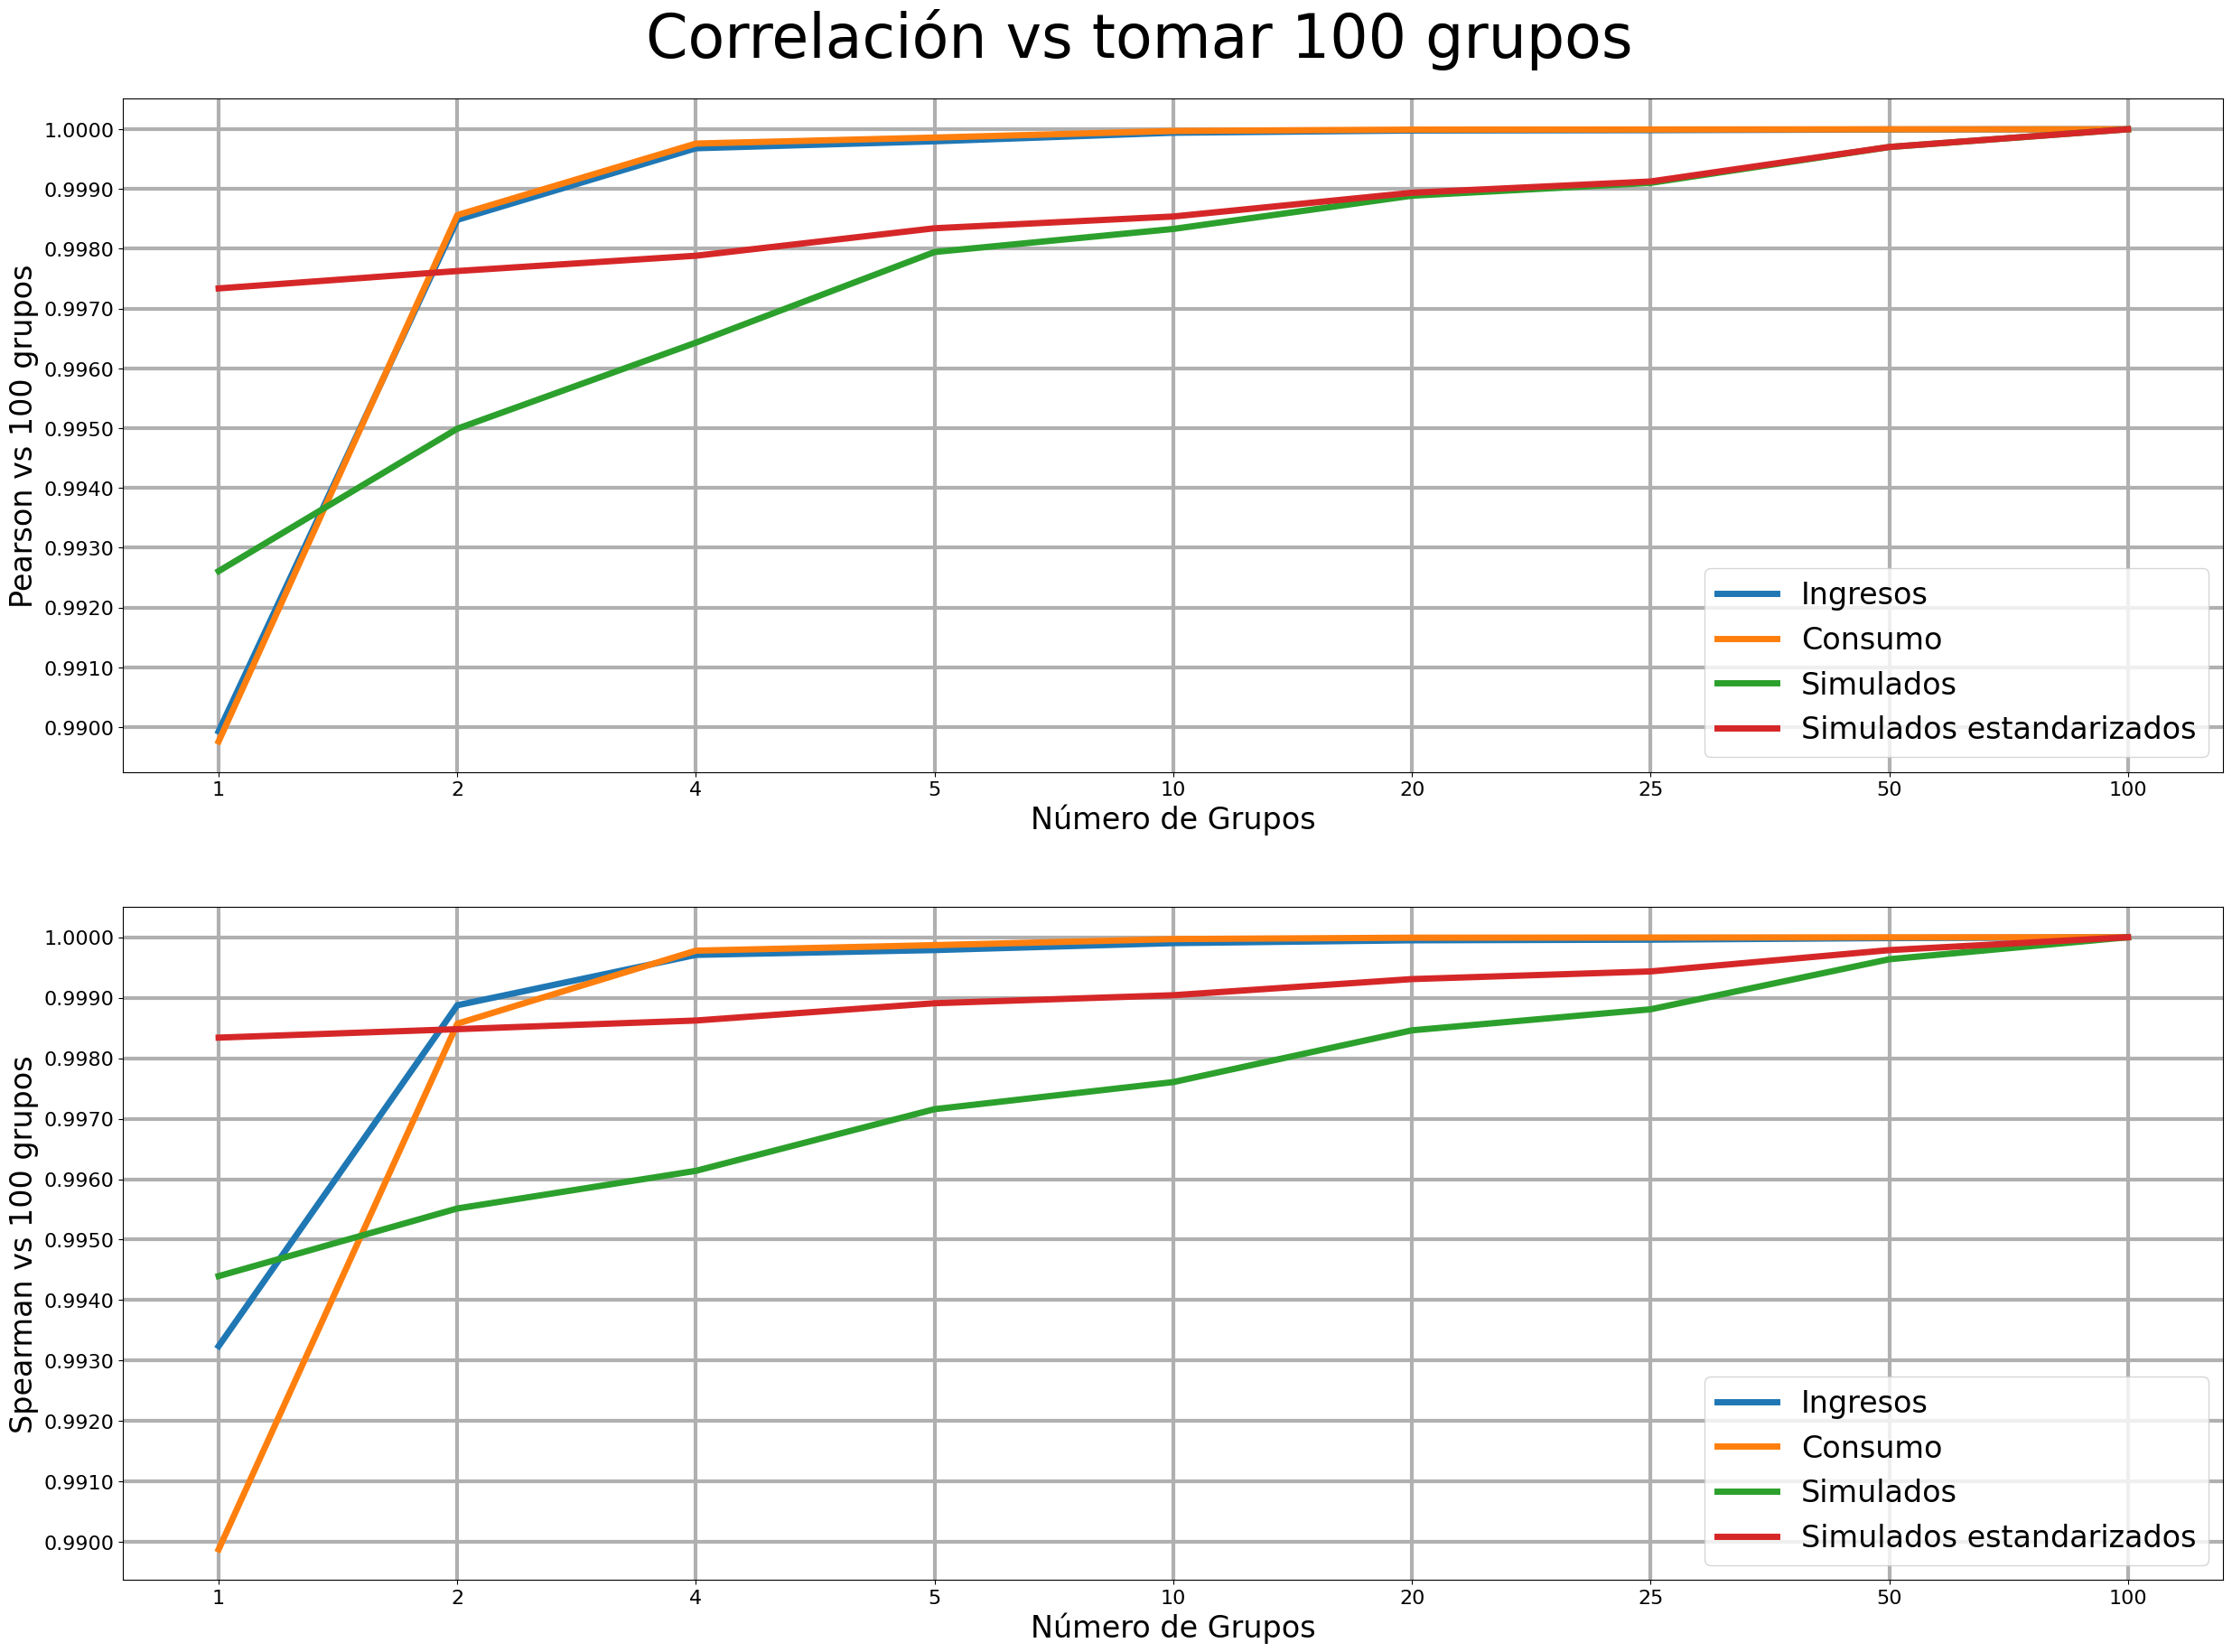

In [26]:
from scipy.stats import pearsonr, spearmanr

fig, axs = plt.subplots(2,1, figsize=(30,20))

x = list(filter(lambda x : 100%x==0, range(1,101)))
x = list(map(str, x))
def Plot(ax, y, corr, label):
    xs = list(range(len(x)))
    ys = [corr(yi,y[-1]).correlation for yi in y]
    ax.plot(xs,ys, label = label, linewidth=5)

sg = simulados.groupby(['-1'])
for (i, corr) in enumerate([pearsonr, spearmanr]):
    Plot(axs[i], var_ingresos,corr, "Ingresos")
    Plot(axs[i], var_consumo,corr, "Consumo")


vals = simulados.to_numpy().T[-(len(x)):]
Plot(axs[0], vals,pearsonr, f"Simulados")
Plot(axs[0], Normalizador(simulados.to_numpy().T[1:])[-len(x):],pearsonr, f"Simulados estandarizados")
Plot(axs[1], vals,spearmanr, f"Simulados")
Plot(axs[1], Normalizador(simulados.to_numpy().T[1:])[-len(x):],spearmanr, f"Simulados estandarizados")
for ax in axs:
    ax.set_xticks(range(len(x)), x, fontsize=16)
    yticks = np.linspace(0.99,1,11)
    ax.set_yticks(
        yticks,
        list(map(lambda x : f"{x:.4f}",yticks)),
        fontsize=16)
    ax.legend(fontsize=24)
    ax.set_xlabel("Número de Grupos", fontsize=24)
    ax.grid(linewidth=3)
axs[0].set_ylabel("Pearson vs 100 grupos", fontsize=24)
axs[1].set_ylabel("Spearman vs 100 grupos", fontsize=24)
fig.suptitle("Correlación vs tomar 100 grupos", fontsize=48)
fig.subplots_adjust(top=0.93) 
plt.show()


/tmp/ipykernel_96959/1152505086.py:15: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  vals = sg.get_group(1).to_numpy().T[1:] #simulados.to_numpy().T[1:]
/home/lautaro/anaconda3/envs/data_11/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/home/lautaro/anaconda3/envs/data_11/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


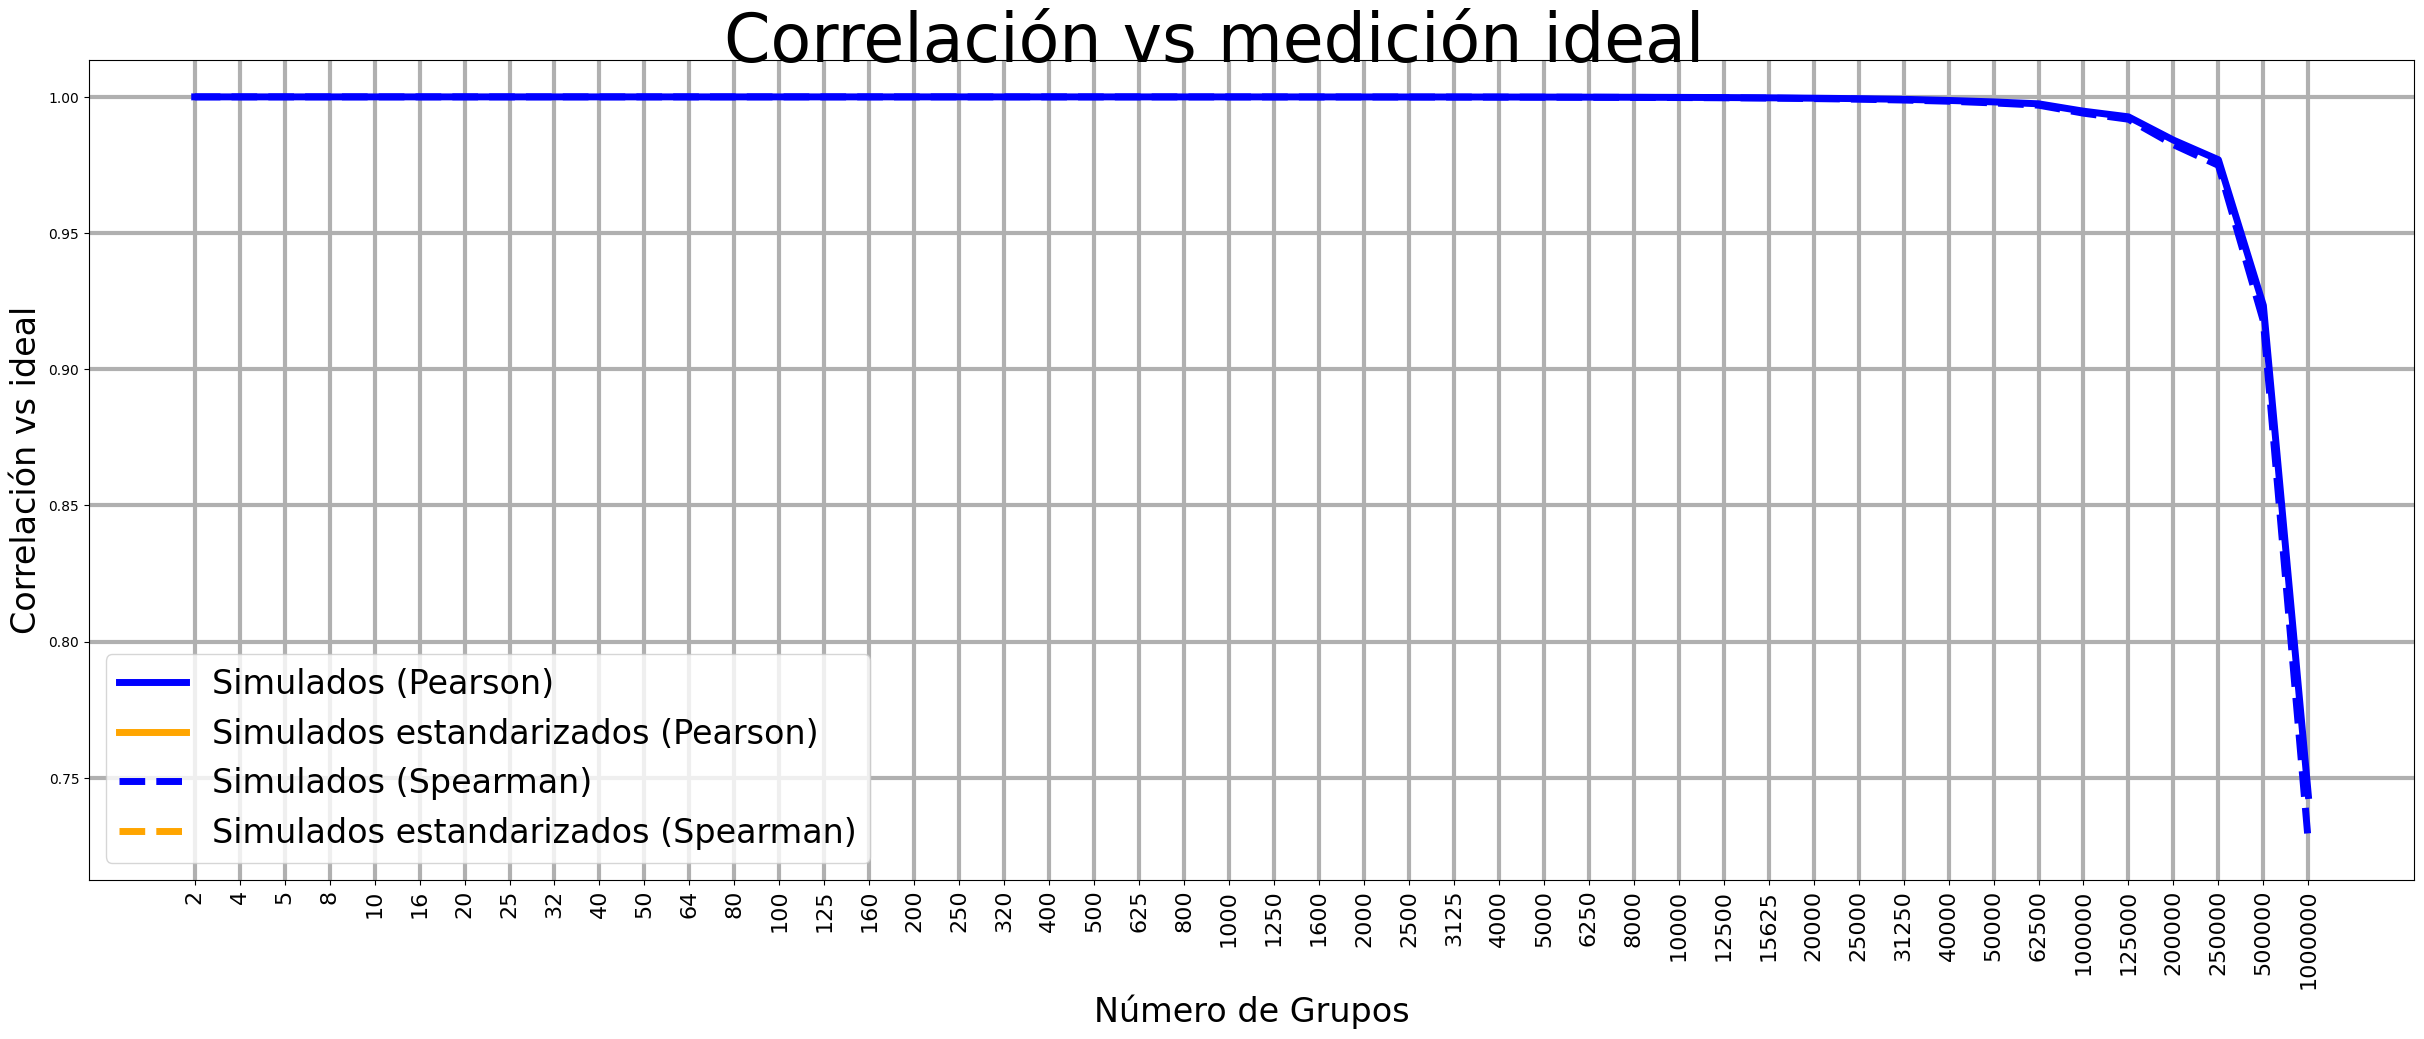

In [53]:
from scipy.stats import pearsonr, spearmanr

fig, ax = plt.subplots(1,1, figsize=(30,10))

x = list(filter(lambda x : 100%x==0, range(1,101)))
x = list(map(str, x))
def Plot(ax, y, corr, label, col, linestyle):
    xs = list(range(len(x)))
    ys = [corr(yi,y[0]).correlation for yi in y[-len(x):]]
    ax.plot(xs,ys, label = label, linewidth=5, c = col, linestyle=linestyle)

sg = simulados.groupby(['-1'])


vals = sg.get_group(1).to_numpy().T[1:] #simulados.to_numpy().T[1:]
vals_norm = Normalizador(vals)
Plot(ax, vals,     pearsonr, f"Simulados (Pearson)", col = "blue", linestyle="-")
Plot(ax, vals_norm,pearsonr, f"Simulados estandarizados (Pearson)",col = "orange", linestyle="-")
Plot(ax, vals,     spearmanr, f"Simulados (Spearman)",col = "blue", linestyle="--")
Plot(ax, vals_norm,spearmanr, f"Simulados estandarizados (Spearman)",col = "orange", linestyle="--")
ax.set_xticks(range(1,len(x)), x[1:], fontsize=16, rotation=90)
#    yticks = np.linspace(0.99,1,11)
#    ax.set_yticks(
#        yticks,
#        list(map(lambda x : f"{x:.4f}",yticks)),
#        fontsize=16)
ax.legend(fontsize=24)
ax.set_xlabel("Número de Grupos", fontsize=24)
ax.grid(linewidth=3)
ax.set_ylabel("Correlación vs ideal", fontsize=24)
fig.suptitle("Correlación vs medición ideal", fontsize=48)
fig.subplots_adjust(top=0.93) 
plt.show()
